# Superstore Sales: Clustering Analysis

## Imports

In [317]:
import warnings
warnings.filterwarnings('ignore')

from reusable import *
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [318]:
# SQLAlchemy Engine
engine = create_engine(generate_url())

In [319]:
df = pd.read_sql_table(table_name='features', con=engine.connect())
df.head(5)

,OrderYear,OrderMonth,DaysToShip,Segment,Region,State,Department,Division,Profit
0,2015,11,4,Corporate,East,Vermont,Furniture,Bookcases,1013.13
1,2016,1,4,Corporate,Central,Wisconsin,Furniture,Bookcases,407.13
2,2017,5,4,Consumer,South,Georgia,Furniture,Bookcases,374.63
3,2016,6,2,Consumer,South,Georgia,Furniture,Bookcases,291.38
4,2016,10,0,Corporate,East,Connecticut,Furniture,Bookcases,271.42


In [320]:
df.shape

(8058, 9)

## Clustering: Model Selection

SKLearn's OneHotEncoder may work too, but for our purposes, we're gonna do this quick and dirty.

In [321]:
# Detect columns as either numeric or categorical
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

print('Numerical Features:', num_cols)
print('Categorical Features:', cat_cols)

Numerical Features: ['OrderYear', 'OrderMonth', 'DaysToShip', 'Profit']
Categorical Features: ['Segment', 'Region', 'State', 'Department', 'Division']


In [322]:
# Encode categorical data with dummy variables, then concatenate back together.
X = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols])], axis=1)

# Correct a TypeError
X.columns = [s.replace('_', '').replace(' ', '') for s in X.columns]
X.columns = X.columns.astype(str)

# Scale data properly
X_scaled = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
X_scaled.head(10)

,OrderYear,OrderMonth,DaysToShip,Profit,SegmentConsumer,SegmentCorporate,SegmentHomeOffice,RegionCentral,RegionEast,RegionSouth,...,DivisionEnvelopes,DivisionFasteners,DivisionFurnishings,DivisionLabels,DivisionMachines,DivisionPaper,DivisionPhones,DivisionStorage,DivisionSupplies,DivisionTables
0,-0.645331,0.970279,0.026219,4.483897,-1.031265,1.514269,-0.47001,-0.492114,1.593870,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
1,0.245551,-2.079180,0.026219,1.648156,-1.031265,1.514269,-0.47001,2.032048,-0.627404,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
2,1.136432,-0.859396,0.026219,1.496074,0.969682,-0.660384,-0.47001,-0.492114,-0.627404,2.231086,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
3,0.245551,-0.554450,-1.112715,1.106511,0.969682,-0.660384,-0.47001,-0.492114,-0.627404,2.231086,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
4,0.245551,0.665333,-2.251649,1.013109,-1.031265,1.514269,-0.47001,-0.492114,1.593870,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
5,-1.536213,-0.249505,1.165153,0.959155,-1.031265,1.514269,-0.47001,-0.492114,-0.627404,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
6,-1.536213,0.970279,1.165153,0.847129,-1.031265,1.514269,-0.47001,-0.492114,1.593870,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
7,0.245551,-0.249505,-1.112715,0.799305,0.969682,-0.660384,-0.47001,-0.492114,-0.627404,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
8,1.136432,-0.249505,-1.112715,0.729114,-1.031265,1.514269,-0.47001,-0.492114,-0.627404,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793
9,1.136432,0.360387,-1.112715,0.695562,0.969682,-0.660384,-0.47001,-0.492114,1.593870,-0.448212,...,-0.180409,-0.159536,-0.327604,-0.217508,-0.094284,-0.452598,-0.32059,-0.298932,-0.140964,-0.119793


In [323]:
X_scaled.shape

(8058, 80)

In [324]:
print('Normal Data:', [col for col in X_scaled.columns if check_normality(X_scaled[col])])

Normal Data: []


**REMARK:** The above reveals that our data is non-Guassian, indicating that KMeans *may* be an inappropriate model. However, this conclusion is not definitive. Further exploration is required to determine if KMeans is a suitable model.

In [325]:
# Search across k to find Inertia (WCSS) and Silhouette Scores
inertial_vals = []
silhouette_vals = []

K_vals  = range(2, 10)
for k in K_vals:
    kmeans = KMeans(k)
    kmeans.fit(X)
    labels = kmeans.labels_

    inertial_vals.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(X, labels))

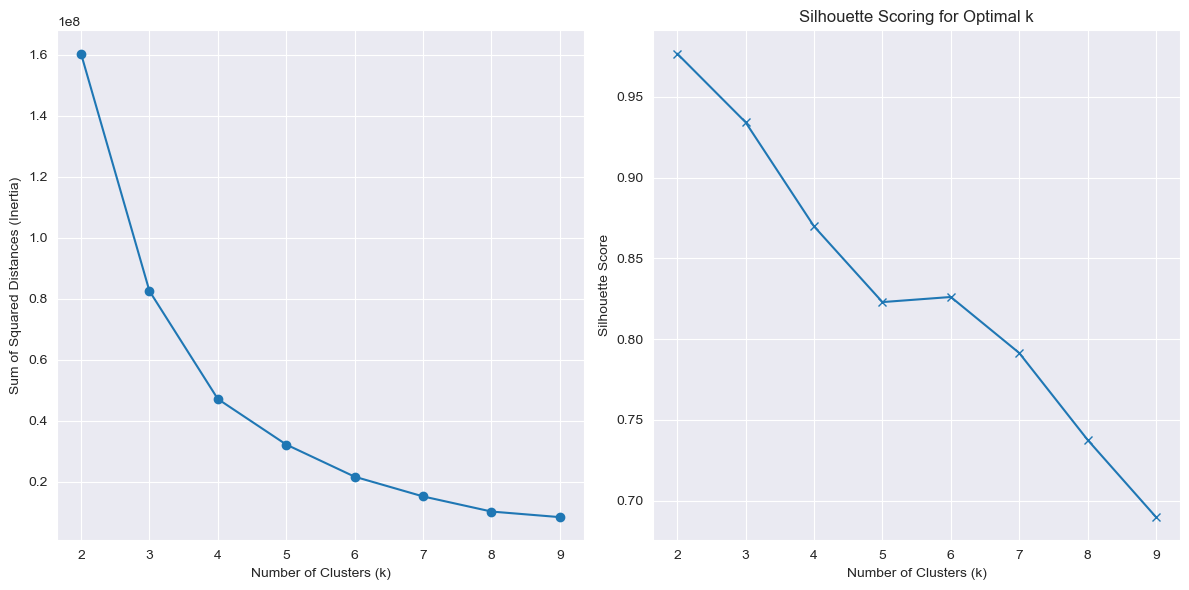

In [326]:
# Graph Inertia and Silhouette Scores
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = ax

ax1.plot(K_vals, inertial_vals, marker='o')
ax2.set_title('Elbow Method for Optimal k')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Sum of Squared Distances (Inertia)')

ax2.plot(K_vals, silhouette_vals, marker='x')
ax2.set_title('Silhouette Scoring for Optimal k')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')

fig.tight_layout()
plt.show()

**INSIGHT:** Both the Elbow Method and Silhouette Score would seem to agree that KMeans with $k=2$ should result in "correct", largely distinct clusters with the KMeans algorithm.

In [327]:
kmeans = KMeans(n_clusters=2, random_state=101).fit(X_scaled)
df['Cluster'] = kmeans.labels_
X_scaled['Cluster'] = kmeans.labels_

In [328]:
df['Cluster'].value_counts()

0    5195
1    2863
Name: Cluster, dtype: int64

## Cluster Analysis

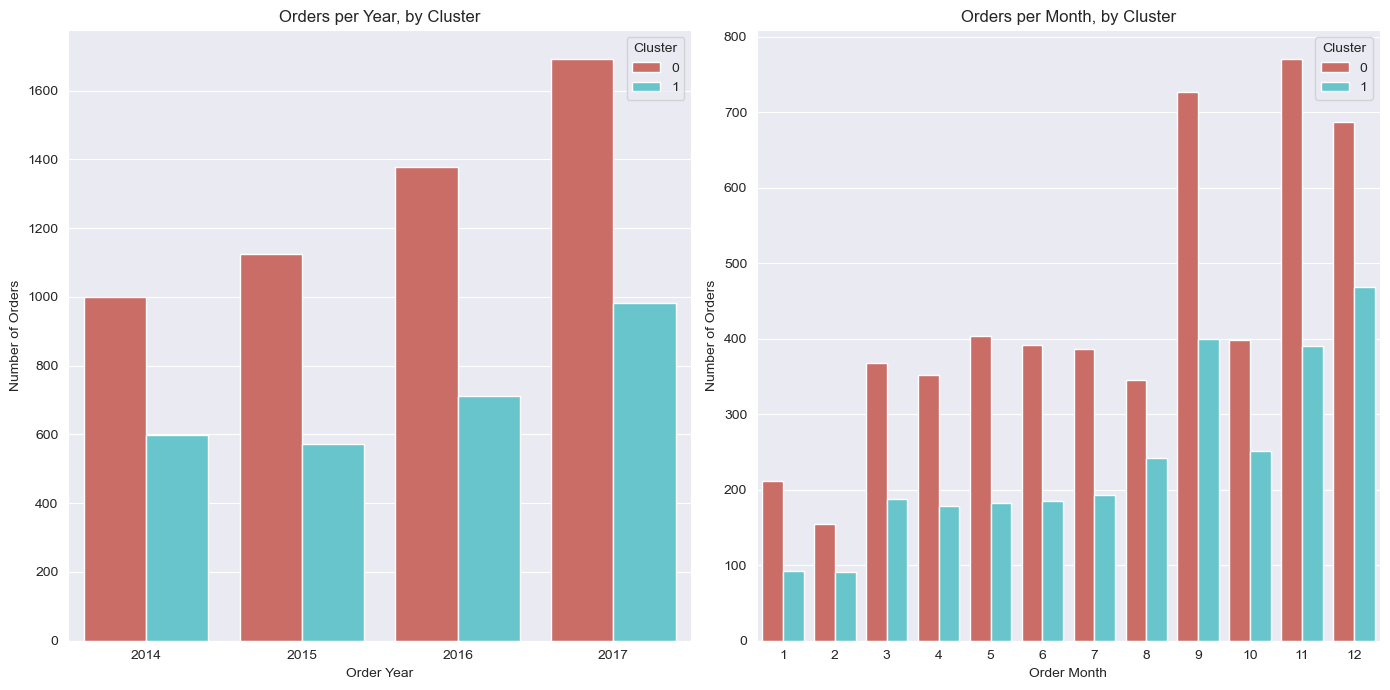

In [329]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax1, ax2 = ax

sns.countplot(data=df, x='OrderYear', hue='Cluster', ax=ax1, palette=sns.color_palette('hls', 2))
ax1.set_xlabel('Order Year')
ax1.set_ylabel('Number of Orders')
ax1.set_title('Orders per Year, by Cluster')

sns.countplot(data=df, x='OrderMonth', hue='Cluster', ax=ax2, palette=sns.color_palette('hls', 2))
ax2.set_xlabel('Order Month')
ax2.set_ylabel('Number of Orders')
ax2.set_title('Orders per Month, by Cluster')

plt.tight_layout()
plt.show()

**REMARK**: In both Clusters, total orders seem to increase year over year. Regardless of proportion, September through December saw the greatest volume overall, though not necessarily indicative of 'Holiday Shopping'.

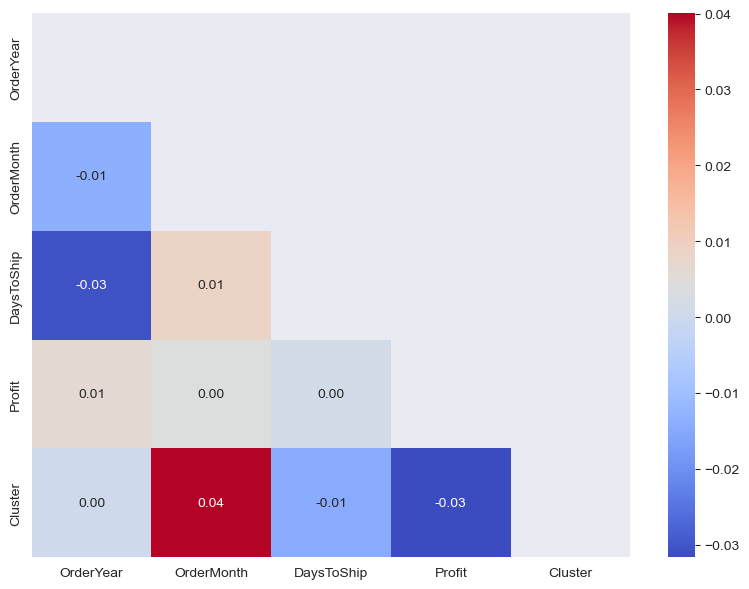

In [330]:
# Correlation for numerical features, now accounting for Cluster
corr_obj = df.select_dtypes(exclude='object').corr()

# Upper triangular mask
mask = np.triu(np.ones_like(corr_obj, dtype=bool))

# Plot heatmap of correlations, applying mask to reduce visual clutter
plt.figure(figsize=(8, 6))
sns.heatmap(corr_obj, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

plt.tight_layout()
plt.show()

**REMARK:** Our (unscaled) numerical features are all very weakly correlated with Cluster, meaning they are unlikely to be decent predictors of Cluster label.

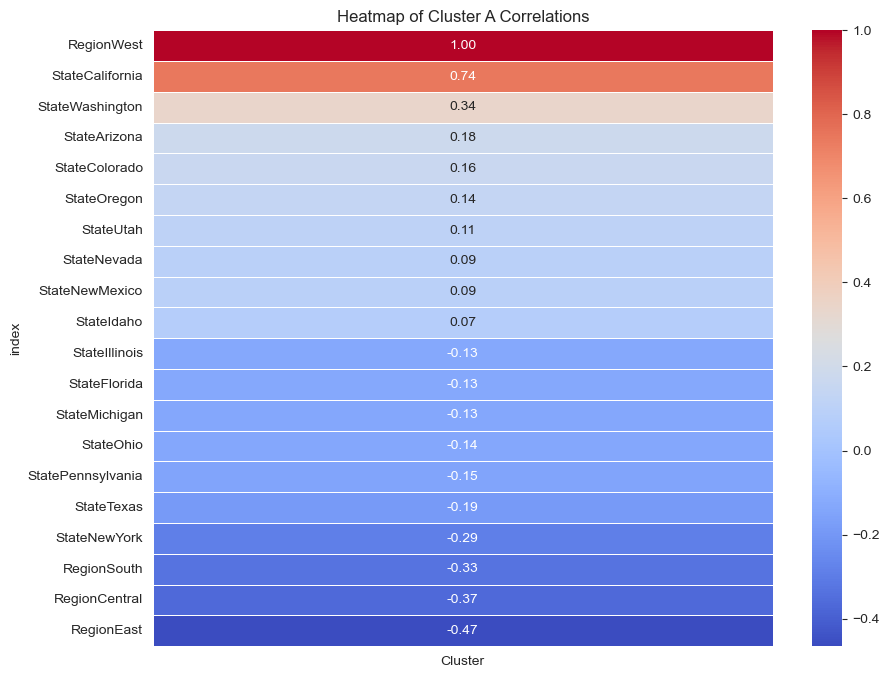

In [331]:
# Calculate and Visualize the 20 most-influential scaled features with respect to Cluster A
corr_slice = X_scaled.corr()['Cluster'].drop(labels='Cluster', axis=0).sort_values(ascending=False)
abv_corr_slice = pd.concat(objs=[corr_slice.head(10), corr_slice.tail(10)], axis=0)
abv_corr_slice_df = abv_corr_slice.reset_index()



plt.figure(figsize=(10, 8))
sns.heatmap(abv_corr_slice_df.set_index('index'), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Cluster A Correlations')
plt.show()

In [338]:
print('Number of Western segment orders Belonging to Cluster B:', df[(df['Region'] == 'West') & (df['Cluster'] == 1)].shape[0])
print('Number of non-Western segment orders Belonging to Cluster A:', df[(df['Region'] == 'West') & (df['Cluster'] == 0)].shape[0])

Number of Western segment orders Belonging to Cluster B: 2863
Number of non-Western segment orders Belonging to Cluster A: 0


**INSIGHT:** In this iteration, Region appears to be the dominant factor in the clustering process. Orders from the Western Region are consistently assigned to Cluster B (1), while orders from elsewhere result in a Cluster A (0) classification. However, in another iteration (not shown), where the ```random_state``` was not specified, Department played a similar role, with Furniture and Technology creating one Cluster, and Office Supplies forming another. Both such variables act as bins for smaller, more specific sub-labels (ex. Division or State). This also highlights the sensitivity of KMeans to initial conditions that are random by default, meaning each iteration without specification of a  ```random_state``` is liable to produce a different result.

In [334]:
engine.connect().close()
engine.dispose()